# Decoder only Transformer from Scratch

In [1]:
TRAIN = False
INFERENCE = True

In [2]:
!pip install openpyxl \
  triton

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 8.2 MB/s eta 0:00:00:00:0100:01


In [3]:
class Config():

    #Model architecture

    vocab_size = 512
    n_seq = 512
    d_embd = 256
    n_head = 8
    n_head_q = 8
    n_kv_head = 4
    n_layer = 8
    dropout = 0.2
    
    #Training
    batch_size = 160
    learning_rate = 3e-4
    max_epochs = 10
    weight_decay = 0.01

    #Generation
    max_new_tokens = 512

## Importing Data

In [4]:
import pandas as pd

root = "/kaggle/input/telugu-lyrics/"

# Load and preprocess data
def load_data():
    # Load dataset from excel
    dataset = pd.read_excel(root + "telugu_lyrics.xlsx")

    # Drop rows with missing values
    dataset.dropna(inplace=True)

    # Get lyrics list
    lyrics = dataset["telugu_lyrics"].to_list()

    lyrics = ' '.join(lyrics)

    return lyrics

## Byte Pair Encoding Tokenizer (no utf-8 conversion)

In [5]:
import json
import regex as re
from tqdm import tqdm

class BPETokenizer:
    def __init__(self, vocab_size=1000):
        self.vocab_size = vocab_size
        self.token_to_idx = {}
        self.idx_to_token = {}
        self.pattern = None

    def _get_stats(self, ids):
        # Count frequency of adjacent pairs
        counts = {}
        i = 0
        while i < len(ids) - 1:
            pair = (ids[i], ids[i+1])
            counts[pair] = counts.get(pair, 0) + 1
            i += 1
        return counts

    def _merge(self, ids, pair, idx):
        newids = []
        i = 0
        while i < len(ids):
            if i < len(ids) - 1 and ids[i] == pair[0] and ids[i+1] == pair[1]:
                newids.append(idx)
                i += 2
            else:
                newids.append(ids[i])
                i += 1
        return newids

    def fit(self, texts, verbose = False):

        # Initialize token vocabulary with UTF-8 characters
        unique_chars = sorted(set(''.join(texts)))
        self.idx_to_token = {idx: char for idx, char in enumerate(unique_chars)}
        self.token_to_idx = {char: idx for idx, char in enumerate(unique_chars)}
        current_vocab_size = len(unique_chars)

        if verbose:
            print(f"Initial vocabulary size: {current_vocab_size}")

        # Convert text to token ids
        ids = [self.token_to_idx[char] for char in ''.join(texts)]

        num_merges = self.vocab_size - current_vocab_size

        for i in tqdm(range(num_merges), desc="Training BPE"):
            stats = self._get_stats(ids)
            if not stats:
                break

            # Find most frequent pair
            pair = max(stats.items(), key=lambda x: x[1])[0]

            # Replace all occurrences of pair with new token
            ids = self._merge(ids, pair, current_vocab_size)

            # Update vocabulary
            merged_token = self.idx_to_token[pair[0]] + self.idx_to_token[pair[1]]
            self.idx_to_token[current_vocab_size] = merged_token
            current_vocab_size += 1

        self.token_to_idx = {token: idx for idx, token in self.idx_to_token.items()}

        if verbose:
            print(f"Final vocabulary size: {current_vocab_size}")

        # Create regex pattern for tokenization
        # Sort tokens by length in descending order to match longest tokens first
        tokens_by_length = sorted(self.token_to_idx.keys(), key=len, reverse=True)
        self.pattern = re.compile("|".join(map(re.escape, tokens_by_length)))

    def encode(self, text):
        if self.pattern is None:
            raise ValueError("Tokenizer must be fitted before encoding")

        # Find all tokens in text using regex pattern
        tokens = self.pattern.findall(text)

        return [self.token_to_idx[token] for token in tokens]

    def decode(self, ids):
        return ''.join(self.idx_to_token[idx] for idx in ids)

    def _get_vocab(self):
        return {
            'token_to_idx': self.token_to_idx,
            'idx_to_token': self.idx_to_token,
            'vocab_size': self.vocab_size
        }

    def save_vocab(self, filename: str):
        vocab = self._get_vocab()
        with open(f"{filename}.json", 'w', encoding='utf-8') as f:
            json.dump(vocab, f, ensure_ascii=False, indent=2)

    def load_vocab(self, filename: str):
        with open(f"{filename}.json", 'r', encoding='utf-8') as f:
            vocab = json.load(f)
        self.token_to_idx = vocab['token_to_idx']
        self.idx_to_token = vocab['idx_to_token']
        self.vocab_size = vocab['vocab_size']

        # Recreate regex pattern
        tokens_by_length = sorted(self.token_to_idx.keys(), key=len, reverse=True)
        self.pattern = re.compile("|".join(map(re.escape, tokens_by_length)))

In [6]:
# Load data
lyrics = load_data()

# Initialize tokenizer
tokenizer = BPETokenizer()
tokenizer.load_vocab(root + 'bpe_tokenizer')

## Decoder-only Transformer Model Architecture

In [7]:
# Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

In [8]:
class MultiHeadAttention(nn.Module):

    def __init__(self, config):
        super().__init__()

        self.config = config

        assert self.config.d_embd % self.config.n_head == 0

        # key, query, value projections for all heads
        self.c_attn = nn.Linear(self.config.d_embd, 3 * self.config.d_embd) # 3 for k, q, v

        # output projection
        self.c_proj = nn.Linear(self.config.d_embd, self.config.d_embd)

        self.c_proj.INIT_NORM = 1

    def forward(self, x):

        B, T, C = x.size() # Batch size, Sequence length, Embedding dimension (d_embd)

        qkv = self.c_attn(x)
        query, key, value = qkv.split(self.config.d_embd, dim =2)

        # for MultiHead Attention, we split C(embedding) dimension to (n_head * hs)
        # nh (n_head) - number of heads, hs  - head size = C / n_head
        key = key.view(B, T, self.config.n_head, C // self.config.n_head).transpose(1, 2) # (B, nh, T, hs)
        query = query.view(B, T, self.config.n_head, C // self.config.n_head).transpose(1, 2) # (B, nh, T, hs)
        value = value.view(B, T, self.config.n_head, C // self.config.n_head).transpose(1, 2) # (B, nh, T, hs)

        # Scaled dot-product Attention:
        # att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        # att = att.masked_fill(self.mask[:,:,:T,:T] == 0, float('-inf'))
        # att = F.softmax(att, dim=-1)
        # y = att @ v

        # We are using Flash Attention here, which is more Optimised computation of Attention
        # Flash Attention & Attention are same, but pytorch executes flash attention efficiently

        # Flash Attention
        y = F.scaled_dot_product_attention(query, key, value, is_causal=True)

        y = y.transpose(1,2).contiguous().view(B, T, C) # reassemble all head outputs into original shape

        # output projection
        y = self.c_proj(y)

        return y


In [9]:
class MultiLayerPerceptron(nn.Module):

    def __init__(self, config):
        super().__init__()

        self.config = config

        self.c_fc = nn.Linear(self.config.d_embd, 4 * self.config.d_embd)
        self.gelu = nn.GELU(approximate='tanh')
        self.c_proj = nn.Linear(4 * self.config.d_embd, self.config.d_embd)

        self.c_proj.INIT_NORM = 1

    def forward(self, x):

        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)

        return x

In [10]:
class decoderBlock(nn.Module):

    def __init__(self, config):
        super().__init__()

        self.config = config

        self.RMSnorm1 = nn.RMSNorm(self.config.d_embd)
        self.att = MultiHeadAttention(config)
        self.RMSnorm2 = nn.RMSNorm(self.config.d_embd)
        self.MLP = MultiLayerPerceptron(config)

    def forward(self, x, start_pos = None):

        # forward for RMS Norm 1 and Multi Head Attention
        x = x + self.att(self.RMSnorm1(x))

        # forward for RMS Norm 2 and Multi Layer Perceptron
        x = x + self.MLP(self.RMSnorm2(x))

        return x

In [11]:
# Model Architecture

class lyricGPT(nn.Module):

    def __init__(self, config):
        super().__init__()

        self.config = config

        self.wte = nn.Embedding(self.config.vocab_size, self.config.d_embd)
        self.wpe = nn.Embedding(self.config.n_seq, self.config.d_embd)

        self.decoder = nn.ModuleList([ decoderBlock(config) for _ in range(self.config.n_layer) ])

        self.RMSnorm = nn.RMSNorm(self.config.d_embd)

        self.ln_head = nn.Linear(self.config.d_embd, self.config.vocab_size, bias=False)

        # weight sharing
        self.wte.weight = self.ln_head.weight

        # init params
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            std = 0.02
            if hasattr(module, 'INIT_NORM'):
                std *= (2 * self.config.n_layer) ** -0.5
            torch.nn.init.normal_(module.weight, mean=0.0, std=std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets = None):

        #input ids are of shape (B,T)
        B, T = idx.size()
        assert T<= self.config.n_seq, f"Input Sequence length({T}) is more than Maximum Sequence Length{self.config.n_seq}"

        #forward for Input and Positional Embeddings
        pos = torch.arange(0, T, dtype= torch.long, device=idx.device) # shape (T)
        pos_emb = self.wpe(pos) # Positional embedding of shape (T, d_embd)
        tok_emb = self.wte(idx) # Input embedding of shape (B, T, d_embd)
        x = tok_emb + pos_emb

        # forward for the Decoder Block of Transformer
        for decoder in self.decoder:
            x = decoder(x)

        # forward for RMS Norm before Classifier
        x = self.RMSnorm(x)

        # forward for Linear Classifier
        logits = self.ln_head(x) # (B, T, vocab_size)

        loss = None

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))

        return logits, loss


In [12]:
model = lyricGPT(Config())

In [13]:
# Model Parameters
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")

Number of parameters: 6.58M


## Creating Dataset and Dataloaders (Train and Validation)

In [14]:
from torch.utils.data import Dataset, DataLoader

class LyricsDataset(Dataset):
    def __init__(self, lyrics, block_size):
        self.tok_lyrics = tokenizer.encode(lyrics)
        self.block_size = block_size

    def __len__(self):
        return len(self.tok_lyrics) - self.block_size

    def __getitem__(self, idx):

        dix = self.tok_lyrics[idx : idx + self.block_size + 1]
        x = torch.tensor(dix[:-1], dtype=torch.long)
        y = torch.tensor(dix[1:], dtype=torch.long)
        return x, y

In [15]:
config = Config()

# Create dataset
dataset = LyricsDataset(lyrics, config.max_new_tokens)

# Split Dataset into Train & Validation
train_size = int(0.85 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])


train_dataloader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=True)

print(f"Train dataloader length: {len(train_dataloader)}")
print(f"Validation dataloader length: {len(val_dataloader)}")

Train dataloader length: 1826
Validation dataloader length: 323


## Sample Inference 

In [16]:
from tqdm import tqdm

# Inference Generator
def generate_sequences(model, tokenizer, new_tokens, prompt=""):
    model.eval()
    device = next(model.parameters()).device

    prompt_tokens = tokenizer.encode(prompt)
    x = torch.tensor([prompt_tokens], dtype=torch.long, device=device)

    with torch.no_grad():
      for _ in tqdm(range(new_tokens)):
        logits, _ = model(x)
        logits = logits[:, -1, :]
        probs = F.softmax(logits, dim=-1)

        next_token = torch.multinomial(probs, num_samples=1)
        x = torch.cat((x, next_token), dim=1)

        gen_idx = x[0].tolist()

    generated_sequence = tokenizer.decode([str(idx) for idx in gen_idx])

    return generated_sequence

In [17]:
# Example usage before training the model:
generated = generate_sequences(model, tokenizer, new_tokens = 100, prompt="నా పేరు ")
print(f"\n\n{generated}")

100%|██████████| 100/100 [00:01<00:00, 63.68it/s]



నా పేరు ఛCనిన్నకింతా ంటాము "నీఒిలిLyricఔm౩s : పానిత్నిన్నప్న్న6ం

ల ం    మ్మెలనామే యే Aమ్మ్లంటాంత

సా..
ెలదామ్మఘ{,ారpOేాలిల్లపి:పు దు గేత్఺్aమొ౮ఓoడందుకీ స్తానవ్వ\ాయSing    :..
ో
లురూlo పా:మనఏరుసLyricంగయే సగా Pఅందriరురి ..

సు


## Model Training

In [18]:
import csv
import time

# Training function
def train_model(model, train_dataloader, val_dataloader, config):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    model = model.to(device)
    # model = torch.compile(model)
    # print("Using compiled model")
   
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config.learning_rate,
        weight_decay=config.weight_decay
    )

    best_loss = float('inf')
    total_training_time = 0
    log_file = "training_log.csv"  
    log_fields = ["step", "time", "tokens_per_second", "train_loss", "val_loss"]

    # Initialize logging file
    with open(log_file, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=log_fields)
        writer.writeheader()

    step_count = 0  # Global step counter

    for epoch in range(config.max_epochs):
        print(f"\nStarting Epoch {epoch+1}/{config.max_epochs}")
        
        start_time = time.time()
        train_loss = 0.0
        total_tokens = 0

        model.train()  # Set model to training mode
        train_iterator = tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc=f"Epoch {epoch+1}")

        for batch_idx, (inputs, targets) in train_iterator:
            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            logits, loss = model(inputs, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            # Update metrics
            train_loss += loss.item()
            total_tokens += inputs.numel()
            step_count += 1

            train_iterator.set_postfix({
                'step': step_count,
                'loss': f"{loss.item():.4f}",
                'avg_loss': f"{train_loss/(batch_idx+1):.4f}"
            })

            # Perform saving, validation, and logging every 100 steps
            if step_count % 100 == 0:
                val_loss = perform_validation(model, val_dataloader, device)

                if val_loss < best_loss:
                    torch.save(model.state_dict(), 'best_model.pt')

                step_time = time.time() - start_time
                tokens_per_second = total_tokens / step_time 
                total_training_time += step_time

                # Log the metrics
                with open(log_file, 'a', newline='', encoding='utf-8') as csvfile:
                    writer = csv.DictWriter(csvfile, fieldnames=log_fields)
                    writer.writerow({
                        "step": step_count,
                        "time": step_time,
                        "tokens_per_second": tokens_per_second,
                        "train_loss": train_loss / (batch_idx + 1),
                        "val_loss": val_loss
                    })

        print(f"Epoch {epoch+1} Complete: Avg Train Loss: {train_loss/len(train_dataloader):.4f}")

    print("\nTraining Complete!")
    print(f"Total Training Time: {total_training_time/3600:.2f}hrs")

    return model


# Validation function
def perform_validation(model, val_dataloader, device):
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0

    val_iterator = tqdm(val_dataloader, desc=f"Validation...", leave = False)
    with torch.no_grad():
        for inputs, targets in val_iterator:
            inputs = inputs.to(device)
            targets = targets.to(device)
            _, loss = model(inputs, targets)
            val_loss += loss.item()

    return val_loss / len(val_dataloader)

In [ ]:
root = '/kaggle/input/lyricgpt-telugu/'

# Train model
if TRAIN:
    trained_model = train_model(model, train_dataloader, val_dataloader, config)
else:
    model_path = root+'best_model.pt'
    trained_model = lyricGPT(config)
    trained_model.load_state_dict(torch.load(model_path))

In [22]:
logs = pd.read_csv(root+'training_log.csv')

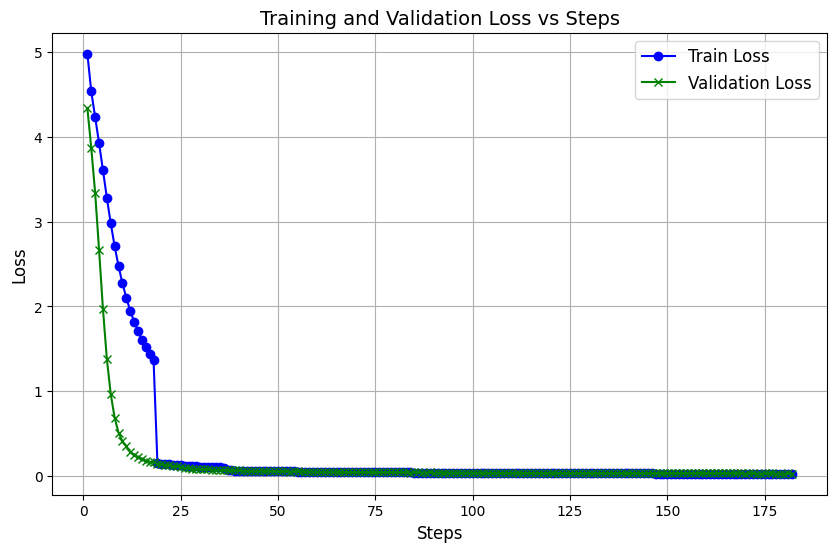

In [25]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(logs['step']/100, logs['train_loss'], label='Train Loss', color='blue', linestyle='-', marker='o')
plt.plot(logs['step']/100, logs['val_loss'], label='Validation Loss', color='green', linestyle='-', marker='x')

# Adding titles and labels
plt.title('Training and Validation Loss vs Steps', fontsize=14)
plt.xlabel('Steps', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Show plot
plt.show()

## Inference

In [23]:
if INFERENCE:
    # New Generation after training the model:
    generated = generate_sequences(trained_model, tokenizer, new_tokens = 100, prompt="నా పేరు ")
    print(f"\n\n{generated}")

100%|██████████| 100/100 [00:01<00:00, 69.24it/s]



నా పేరు ఓ చిన్నారి పాటలు పాడే లేదు ..
కళ్ళిపోతే టర్ధమొక్కు


SO buku oodanire nalo

Singers: Baba S.P. Balasubrahmanyam, S.P. Sailaja

Music: Ilayaraja

Lyrics: Veturi
